# MCMC vs OFTI Comparison

- purpose of tutorial: help folks understand differences between MCMC and OFTI enough to choose which algorithm to use
- reference Blunt et al 2017, suggest trying to get basic understanding of how OFTI and MCMC work before starting tutorial.


- generate synthetic data that's good for OFTI, do OFTI/MCMC fit
    - show that MCMC is not converged
    - explain why OFTI is fast in this regime
- generate synthetic data that's good for MCMC, show that OFTI takes a while just to get 1 orbit, show that MCMC is well converged
- generate data that's good for both, make Q-Q plot to prove they give the same result

**NOTE**: "convergence" is defined differently for OFTI and for MCMC. For OFTI, the algorithm just needs to accept enough orbits for the results to be statistically significant. For MCMC, convergence is a bit more complicated, but at a high level an MCMC run has converged when all walkers have explored the entire parameter space. There are several metrics for estimating MCMC convergence (e.g. GR statistic, min Tz statistic), but we'll just go for a qualitative picture in this tutorial. 

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.table

from orbitize.kepler import calc_orbit
from orbitize import system, sampler

## Short Orbital Fraction

When comparing OFTI and MCMC, I will use "orbital fraction," or the fraction of the orbit spanned by the astrometric observations, as a figure of merit. In general, OFTI will converge faster than MCMC for small orbital fractions. 

Let's start by generating some synthetic data over a short orbital fraction. 

This planet has a period of 150.0 yrs. Observations cover 3.0 years, so the orbital fraction is 2.01%.


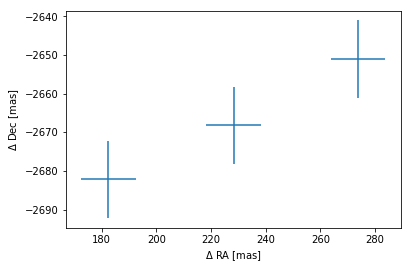

In [64]:
# ground truth
sma = 30 # semimajor axis [au]
ecc = 0.5
inc = np.pi/4 # inclination [radians]
argp = 0.
lan = 0.
tau = 0.5
mstar = 1.2 # stellar mass [M_sol]
plx = 60.0 # parallax [mas]

# calculate RA/Dec at three observation epochs
observation_epochs = np.linspace(51550., 52650., 3) # 3 epochs between ~2000 and ~2003 [MJD]
num_obs = len(observation_epochs)
ra, dec, _ = calc_orbit(observation_epochs, sma, ecc, inc, argp, lan, tau, plx, mstar)

# add Gaussian noise to simulate measurement
radec_uncertainty = 10.0 # assumed uncertainty on RA & Dec [mas]
ra += np.random.normal(scale=radec_uncertainty)
dec += np.random.normal(scale=radec_uncertainty)

ra_err = np.ones(num_obs)*radec_uncertainty
dec_err = np.ones(num_obs)*radec_uncertainty

# plot the simulated data, for good measure
plt.errorbar(
    ra, dec, yerr=ra_err, xerr=dec_err, linestyle=''
)
plt.xlabel('$\\Delta$ RA [mas]'); plt.ylabel('$\\Delta$ Dec [mas]')

period = np.sqrt((sma**3)/mstar)
orbit_coverage = (max(observation_epochs) - min(observation_epochs))/365.25 # [yr]
print("This planet has a period of {} yrs. Observations cover {} years, so the orbital fraction is {}%.".format(
        np.round(period, 1),
        np.round(orbit_coverage,1),
        np.round(100*orbit_coverage/period,2)
    )
)

The orbit fraction above is typical in direct imaging. Let's fit our synthetic data using OFTI:

In [65]:
# set up orbitize objects

data_table = astropy.table.Table(
    [observation_epochs, [1]*num_obs, ra, ra_err, dec, dec_err, ["radec"]*num_obs], 
    names=('epoch', 'object', 'quant1', 'quant1_err', 'quant2', 'quant2_err', 'quant_type')
)

my_system = system.System(1, data_table, mstar, plx)
my_sampler = sampler.OFTI(my_system)

# print out the data table, for the lolz
data_table

epoch,object,quant1,quant1_err,quant2,quant2_err,quant_type
float64,int64,float64,float64,float64,float64,str5
51550.0,1,2665.1187153772657,14.142135623730951,174.10457239626282,45.0,radec
52100.0,1,2677.9618091960524,14.142135623730951,175.11174518491075,45.0,radec
52650.0,1,2688.408020662702,14.142135623730951,176.11013867697545,45.0,radec


In [67]:
# perform OFTI fit

num2accept = int(1e3) # run OFTI until this many orbits are accepted

_ = my_sampler.run_sampler(num2accept)

In [ ]:
- make above into 